<h2>About this Project</h2>
<p> In this project, you are going to implement AdaBoost for Regression Trees.</p>

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>
</ol>
<p>You can also download a copy of this notebook in multiple formats using the <strong>Download as</strong> option in the <strong>File</strong> menu above.</p>

### Getting Started

Before you get started, let's import a few packages that you will need.

In [1]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
from helper import *
%matplotlib notebook

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.7.3


In addition, we'll create a 2D spiral dataset of size 150 for visualization and a high dimensional dataset <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which we will use as our binary test classification problem.

In [2]:
xTrSpiral,yTrSpiral,xTeSpiral,yTeSpiral= spiraldata(150)
xTrIon,yTrIon,xTeIon,yTeIon= iondata()

<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the spiral data set. </p>

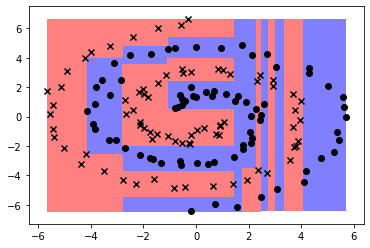

Training error: 0.0000
Testing error:  0.1200


In [3]:
def visclassifier(fun,xTr,yTr):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    
    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
                   )

    plt.axis('tight')
    # shows figure and blocks
    plt.show()
    

tree=RegressionTree(depth=np.inf)
tree.fit(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X: tree.predict(X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

<h2>Boosting in Action</h2>
<h3>Part One: Implement <code>evalboostforest</code> [Graded]</h3>

<p>Another option to improve your decision trees is to build trees of small depth (e.g. only depth=3 or depth=4). These do not have high variance, but instead suffer from <b>high bias</b>. You can reduce the bias of a classifier with boosting. 

<h4>Sample weights</h4>
<p>Before we get started with boosting, we have to ensure that our classifier can handle data sets with <b>sample weights</b>. Luckily we have already implemented a regression tree that can incorporate weights of training examples. Consider you have training examples $(\mathbf{x}_i, y_i)$ and you want to weigh each example with a positive weight $w_i$ during training. Then essentially what you want to do is to create a regression tree that minimizes:
$$ \frac{1}{Z}\sum_{i=1}^n  w_i(tree(\mathbf{x}_i) - y_i)^2 \textrm{ where: } Z=\sum_{j=1}^n w_j$$
</p>

<p>Note that the constant $\frac{1}{Z}$ makes no practical difference and we include it only for mathematical convenience (this way weights are normalized and can be viewed as probabilities). 
Note that if we set the weights to be one for all training examples (i.e. $w_i = 1$ for every training examples), we recover the decision tree we implemented in the previous project. This extra weighting feature is useful you implement AdaBoost. If $w_1=5$ and $w_{i>1}=1$, the resulting tree should be identical to the tree we would have obtained if we had replicated the first example five times in and used the standard tree building algorithm. </p>

<p>The following cell is an example where we create a tree with randomly weighted training samples. Note that the training error should always be 0, but the weighing does have random effects on the test error. You can see this if you execute the code multiple times. </p>

In [4]:
# Generate random weights
# weights[i] is the weight for i-th training example
weights = np.random.rand(len(xTrSpiral))

# Train a regression tree with the prespecified weights
# the default for weights is None which weigh all training examples equally
tree = RegressionTree(depth=np.inf, weights=weights)

# To fit/train the regression tree
tree.fit(xTrSpiral, yTrSpiral)

# To use the trained regression tree to make score
score = tree.predict(xTrSpiral)

# convert the score into +1/-1 prediction
pred = np.sign(score)

tr_err   = np.mean((np.sign(tree.predict(xTrSpiral)) - yTrSpiral)**2)
te_err   = np.mean((np.sign(tree.predict(xTeSpiral)) - yTeSpiral)**2)

print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

Training error: 0.0000
Testing error:  0.0867


<h4>Weighted trees</h4>
<p>The second change we need for Boosting is to evaluate <b>weighted trees</b>. Similar to bagging, in boosting we obtain ensembles of classifiers $h_1,\dots,h_m$. However, this time we also  associated with weights $\alpha_1,\dots,\alpha_m$ <i>and</i> we sum up the weighted <i>signs</i> of the predictions.  </p>
<p>To be more precise, you should implement the function <code>evalboostforest</code>, which takes as input a set of $m$ trees, $h_1,\dots,h_m$, a set of $m$ corresponding weights $\alpha_1,\dots,\alpha_m$ and a set of $n$ test samples. For each test sample $\mathbf{x}$ evalforest should output the following prediction
$$H(\mathbf{x})= \sum_{i=1}^m \alpha_i \textrm{sign}(h_i(\mathbf{x})).$$
(We make the tree weights $\alpha$ optional, and set them to $\alpha_i=\frac{1}{m}$ if they are not passed on.)
</p>

In [5]:
def evalboostforest(trees, X, alphas=None):
    """Evaluates X using trees.
    
    Input:
        trees:  list of TreeNode decision trees of length m
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector
        
    Output:
        pred: n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    
    if alphas is None:
        alphas = np.ones(m) / len(trees)
            
    pred = np.zeros(n)
    
    # BEGIN SOLUTION
    for t in range(m):
        pred += alphas[t] * np.sign(trees[t].predict(X))      

    # END SOLUTION
    return pred

In [6]:
def evalboostforest_test0():
    m = 200
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m) # create a list of trees 
    preds = evalboostforest(trees, x)
    return preds.shape == y.shape

def evalboostforest_test1():
    m = 200
    x = np.random.rand(10,3)
    y = np.ones(10)
    x2 = np.random.rand(10,3)

    max_depth = 0
    
    # Create a forest with trees depth 0
    # Since the data are all ones, each tree will return 1 as prediction
    trees = forest(x, y, m, max_depth) # create a list of trees      
    pred = evalboostforest(trees, x2)[0]
    return np.isclose(pred,1)  # the prediction should be equal to the sum of weights

def evalboostforest_test2(): 
    # results should match evalforest if alphas are 1/m and labels +1, -1
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.sign(np.arange(100))
    trees = forest(x, y, m) # create a list of m trees 

    alphas=np.ones(m)/m
    preds1 = evalforest(trees, x)
    preds2 = evalboostforest(trees, x, alphas)
    return np.all(np.isclose(preds1,preds2))

def evalboostforest_test3(): 
    # results should NOT match evalforest if alphas are 1/m and labels NOT +1, -1
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m) # create a list of m trees

    alphas=np.ones(m)/m
    preds1 = evalforest(trees, x)
    preds2 = evalboostforest(trees, x, alphas)
    return not(np.all(np.isclose(preds1,preds2)))

def evalboostforest_test4(): 
    # if only alpha[i]=1 and all others are 0, the result should match exactly 
    # the predictions of the ith tree
    m = 20
    x = np.random.rand(100,5)
    y = np.arange(100)
    x2 = np.random.rand(20,5)

    trees = forest(x, y, m)  # create a list of m trees
    allmatch=True
    for i in range(m): # go through each tree i
        alphas=np.zeros(m)
        alphas[i]=1.0; # set only alpha[i]=1 all other alpha=0
        preds1 = np.sign(trees[i].predict(x2)) # get prediction of ith tree
        preds2 = evalboostforest(trees, x2, alphas) # geet prediction of weighted ensemble
        allmatch=allmatch and all(np.isclose(preds1,preds2))
    return allmatch


# and some new tests to check if the weights (and the np.sign function) were incorporated correctly 
runtest(evalboostforest_test0, 'evalboostforest_test0')
runtest(evalboostforest_test1, 'evalboostforest_test1')
runtest(evalboostforest_test2, 'evalboostforest_test2')
runtest(evalboostforest_test3, 'evalboostforest_test3')
runtest(evalboostforest_test4, 'evalboostforest_test4')

Running Test: evalboostforest_test0 ... ✔ Passed!
Running Test: evalboostforest_test1 ... ✔ Passed!
Running Test: evalboostforest_test2 ... ✔ Passed!
Running Test: evalboostforest_test3 ... ✔ Passed!
Running Test: evalboostforest_test4 ... ✔ Passed!


In [7]:
# Autograder test cell - worth 1 point
# runs evalboostforest_test0
### BEGIN HIDDEN TESTS
assert evalboostforest_test0()
### END HIDDEN TESTS

In [8]:
# Autograder test cell - worth 1 point
# runs evalboostforest_test1
### BEGIN HIDDEN TESTS
assert evalboostforest_test1()
### END HIDDEN TESTS

In [9]:
# Autograder test cell - worth 1 point
# runs evalboostforest_test2
### BEGIN HIDDEN TESTS
assert evalboostforest_test2()
### END HIDDEN TESTS

In [10]:
# Autograder test cell - worth 1 point
# runs evalboostforest_test3
### BEGIN HIDDEN TESTS
assert evalboostforest_test3()
### END HIDDEN TESTS

In [11]:
# Autograder test cell - worth 1 point
# runs evalboostforest_test4
### BEGIN HIDDEN TESTS
assert evalboostforest_test4()
### END HIDDEN TESTS

<h3>Part Two: Implement <code>boosttree</code> [Graded]</h3>

Implement the function <code>boosttree</code>, which applies Adaboost to the decision tree model. You can use the pseudo-code in the Adaboost Cheat Sheet to help construct the function. You can also use your <code>evalboostforest</code> function to evaluate your boosted ensemble (provdided you pass on the weights correctly.)</p>

In [12]:
def boosttree(x,y,maxiter=100,maxdepth=2):
    """Learns a boosted decision tree.
    
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree
        
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
        
    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1 
    n,d = x.shape
    weights = np.ones(n) / n
    preds   = None
    forest  = []
    alphas  = []

    ### BEGIN SOLUTION 
    for i in range(maxiter):
        tree = RegressionTree(depth=maxdepth, weights=weights)
        tree.fit(x, y)
        preds = np.sign(tree.predict(x))
        results = (preds != y)
        err = np.sum(results * weights)
        if err > 0.5 - np.finfo(float).eps:
            print("error is too large?", err, "max error", 0.5 - np.finfo(float).eps or abs(err) < np.finfo(float).eps)
            break
        elif abs(err) < np.finfo(float).eps:
            # classification is so simple that one tree is enough
            return [tree], [1]
        
        alpha = 0.5 * np.log((1-err)/err)
        forest.append(tree)
        alphas.append(alpha)
        weights = weights*np.exp(alpha * (results*2 - 1))
        weights = weights/sum(weights)
    ### END SOLUTION
    
    return forest, alphas

In [13]:
def boosting_test1():
    maxiter = 50
    maxdepth = 4
    xTr = np.random.rand(500,3) - 0.5
    yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
    xTe = np.random.rand(50,3) - 0.5
    yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])
    
    out = boosttree(xTr, yTr, maxiter, maxdepth)
    return len(out) == 2 #  boosttrees function should return a tuple

def boosting_test2():
    maxiter = 50
    maxdepth = 4
    xTr = np.random.rand(500,3) - 0.5
    yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
    xTe = np.random.rand(50,3) - 0.5
    yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])
    
    trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
    return len(trees) == len(alphas) #  the len of the two returned output should be the same

def boosting_test3():
    maxiter = 50
    maxdepth = 3
    xTr = np.random.rand(500,3) - 0.5
    yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
    xTe = np.random.rand(50,3) - 0.5
    yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

    tree = RegressionTree(maxdepth)
    tree.fit(xTr, yTr)
    oneacc = np.sum(np.sign(tree.predict(xTe)) == yTe)

    trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
    multiacc = np.sum(np.sign(evalboostforest(trees, xTe, alphas)) == yTe)
    return multiacc >= oneacc

runtest(boosting_test1, 'boosting_test1')
runtest(boosting_test2, 'boosting_test2')
runtest(boosting_test3, 'boosting_test3')

Running Test: boosting_test1 ... ✔ Passed!
Running Test: boosting_test2 ... ✔ Passed!
Running Test: boosting_test3 ... ✔ Passed!


In [14]:
# Autograder test cell - worth 1 point
# runs boosting_test1
### BEGIN HIDDEN TESTS
maxiter = 50
maxdepth = 4
xTr = np.random.rand(500,3) - 0.5
yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
xTe = np.random.rand(50,3) - 0.5
yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

out = boosttree(xTr, yTr, maxiter, maxdepth)
assert len(out) == 2 #  boosttrees function should return a tuple
### END HIDDEN TESTS

In [15]:
# Autograder test cell - worth 1 point
# runs boosting_test2
### BEGIN HIDDEN TESTS
maxiter = 50
maxdepth = 4
xTr = np.random.rand(500,3) - 0.5
yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
xTe = np.random.rand(50,3) - 0.5
yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
assert len(trees) == len(alphas) #  the len of the two returned output should be the same
### END HIDDEN TESTS

In [16]:
# Autograder test cell - worth 1 point
# runs boosting_test3
### BEGIN HIDDEN TESTS
maxiter = 50
maxdepth = 3
xTr = np.random.rand(500,3) - 0.5
yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
xTe = np.random.rand(50,3) - 0.5
yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

tree = RegressionTree(maxdepth)
tree.fit(xTr, yTr)
oneacc = np.sum(np.sign(tree.predict(xTe)) == yTe)

trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
multiacc = np.sum(np.sign(evalboostforest(trees, xTe, alphas)) == yTe)
assert multiacc >= oneacc
### END HIDDEN TESTS

<h3>Evaluate Test and Training Error</h3>

<p>The following script evaluates the test and training error of a boosted forest as we increase the number of trees. The plot shows nicely that the boosting training error is bounded above by the exponential loss, which is rapidly approaching zero. This is one of the nice aspects of boosting, it turns an ensemble of weak learners into a strong learner, that can always achieve 0 training error in a small number of iterations. </p>

[0] exp loss = 0.5022 training err = 0.0676	testing err = 0.1429
[1] exp loss = 0.2779 training err = 0.0676	testing err = 0.1429
[2] exp loss = 0.1300 training err = 0.0107	testing err = 0.1857
[3] exp loss = 0.0712 training err = 0.0214	testing err = 0.2429
[4] exp loss = 0.0417 training err = 0.0000	testing err = 0.1429
[5] exp loss = 0.0172 training err = 0.0000	testing err = 0.0857
[6] exp loss = 0.0131 training err = 0.0000	testing err = 0.1143
[7] exp loss = 0.0085 training err = 0.0000	testing err = 0.1000
[8] exp loss = 0.0041 training err = 0.0000	testing err = 0.1143
[9] exp loss = 0.0022 training err = 0.0000	testing err = 0.1143
[10] exp loss = 0.0013 training err = 0.0000	testing err = 0.1000
[11] exp loss = 0.0006 training err = 0.0000	testing err = 0.0714
[12] exp loss = 0.0003 training err = 0.0000	testing err = 0.0714
[13] exp loss = 0.0002 training err = 0.0000	testing err = 0.0571
[14] exp loss = 0.0001 training err = 0.0000	testing err = 0.1143
[15] exp loss = 0.00

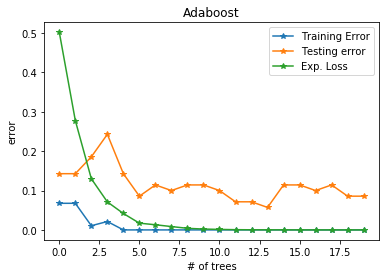

In [17]:
M=20 # max number of trees
alltrees,allalphas=boosttree(xTrIon,yTrIon,maxdepth=3,maxiter=M)

err_trB=[]
loss_trB=[]
err_teB=[]
for i in range(M):
    trees=alltrees[:i+1]
    alphas=allalphas[:i+1]
    trErr = np.mean(np.sign(evalboostforest(trees,xTrIon,alphas)) != yTrIon)
    trLoss =np.mean(np.exp(-evalboostforest(trees,xTrIon,alphas)*yTrIon))
    teErr = np.mean(np.sign(evalboostforest(trees,xTeIon,alphas)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    loss_trB.append(trLoss)
    print("[%d] exp loss = %.4f training err = %.4f\ttesting err = %.4f" % (i,trLoss,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB, '-*', label="Training Error")
line_te, = plt.plot(range(M),err_teB, '-*', label="Testing error")
line_trloss,=plt.plot(range(M),loss_trB, '-*', label='Exp. Loss')
plt.title("Adaboost")
plt.legend(handles=[line_tr, line_te,line_trloss])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

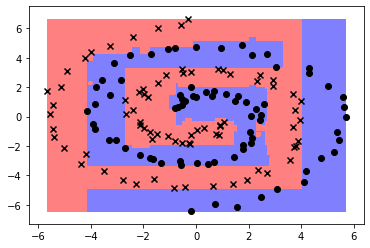

Training error: 0.0000
Testing error:  0.0800


In [18]:
trees,alphas=boosttree(xTrSpiral,yTrSpiral,maxdepth=3,maxiter=50)
visclassifier(lambda X:evalforest(trees,X,alphas),xTrSpiral,yTrSpiral)

print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral)) != yTeSpiral))

<h3>Interactive Demo</h3>

The following demo visualizes the boosted classifier. Add your own points directly on the graph with click and shift+click to see the prediction boundaries. There will be a delay between clicks as the new classifier is trained.

<IPython.core.display.Javascript object>


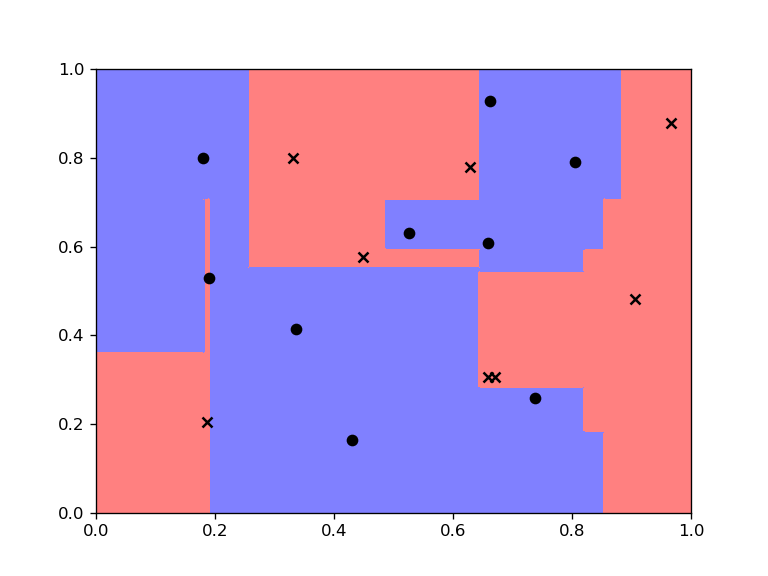

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [19]:
xTrain= np.array([[5,6],[2,5]])
yTrain = np.array([-1,1])


def onclick_boost(event):
    """
    Visualize boosting, including new point
    """
    global xTrain,yTrain
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
            
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0,1,res)
    yrange = np.linspace(0,1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T
    
    # get forest
    forest,alphas=boosttree(xTrain,yTrain,maxdepth=3,maxiter=5)
    if len(forest) > 0:
        fun = lambda X: evalboostforest(forest,X,alphas)
        # test all of these points on the grid
        testpreds = fun(xTe)

        # reshape it back together to make our grid
        Z = testpreds.reshape(res, res)
        Z[0,0] = 1 # optional: scale the colors correctly

        plt.cla()    
        plt.xlim((0,1))
        plt.ylim((0,1))
        # fill in the contours for these predictions
        plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()


%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_boost)
plt.title('Use shift-click to add negative points.')